**Imports**

In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from tqdm import tqdm

import random

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

from framework.siamese.prototypes.siamese import SiameseBrainDataset, SiameseSubset, SiameseNetwork

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    device = torch.device("mps" if torch.mps.is_available() else "cpu")

device

device(type='cuda')

**Constants**

In [41]:
IMG_SIZE = 128
BATCH_SIZE = 64
NUM_EPOCHS = num_epochs = 5
TRAIN_PAIRS = 10000
TEST_PAIRS = 1000

**Dataset Images**

In [42]:
TRAIN_PATH = '../data/train/'
TEST_PATH = '../data/test/'

classes = [
    'meningioma', # 1
    'notumor', # 0
]

# Count classes
train_count = {}
test_count = {}

for c in classes:
    train_count[c] = len(os.listdir(TRAIN_PATH + c))
    test_count[c] = len(os.listdir(TEST_PATH + c))


# Possible number of pairs
train_pairs = train_count['meningioma'] * train_count['notumor']
test_pairs = test_count['meningioma'] * test_count['notumor']

print(f'Train images: {train_count}')
print(f'Test images: {test_count}')

print(f'Train pairs: {train_pairs}')
print(f'Test pairs: {test_pairs}')

Train images: {'meningioma': 1339, 'notumor': 1595}
Test images: {'meningioma': 306, 'notumor': 405}
Train pairs: 2135705
Test pairs: 123930


**Dataset Generation**

In [ ]:
# Dataset and DataLoader setup
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    # Grayscale
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Augmentations
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = SiameseBrainDataset(
    TRAIN_PATH, 
    n_pairs=TRAIN_PAIRS,  # Adjust number of pairs as needed
    transform=train_transform
)

test_dataset = SiameseBrainDataset(
    TEST_PATH, 
    n_pairs=TEST_PAIRS,  # Adjust number of pairs as needed
    transform=test_transform
)

# Create datasets and dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

# Define split ratios
VAL_RATIO = 0.2
val_size = int(len(test_dataset) * VAL_RATIO)
test_size = len(test_dataset) - val_size

# Split the test dataset into validation and test sets
val_indices = list(range(val_size))
test_indices = list(range(val_size, len(test_dataset)))

# Create Subset datasets
val_dataset = SiameseSubset(test_dataset, val_indices)
test_dataset = SiameseSubset(test_dataset, test_indices)

# Create DataLoaders for val and test datasets
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)


**Siamese Network Definition**

In [14]:
model = SiameseNetwork(embedding_dim=128)
model = model.to(device)

**Training**

In [15]:
def contrastive_loss(embedding1, embedding2, label, margin=1.0):
    # Calculate euclidean distance
    distance = torch.nn.functional.pairwise_distance(embedding1, embedding2)
    
    # Calculate loss components
    similar_pair_loss = label * torch.pow(distance, 2)
    dissimilar_pair_loss = (1-label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    
    # Total loss
    loss = (similar_pair_loss + dissimilar_pair_loss) / 2.0
    
    return loss.mean()

In [16]:
from tqdm import tqdm

history = {'train_loss': [], 'val_loss': []}

def train(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0

    # Wrap the DataLoader with tqdm for the progress bar
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for i, (img_pairs, labels) in enumerate(progress_bar):
        # Expect img_pairs to be pairs of images
        img1, img2 = img_pairs[:, 0], img_pairs[:, 1]  # Split pairs
        img1, img2 = img1.to(device), img2.to(device)
        labels = labels.float().to(device)  # Convert labels to float

        optimizer.zero_grad()

        # Forward pass through the Siamese network
        embeddings1, embeddings2 = model(img1, img2)

        # Calculate contrastive loss
        loss = contrastive_loss(embeddings1, embeddings2, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update progress bar description with batch loss and running loss
        progress_bar.set_postfix(
            batch_loss=loss.item(),
            running_loss=running_loss / (i + 1)
        )

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def train_siamese(model, train_loader, val_loader, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        # Train the model
        train_loss = train(model, train_loader, optimizer, device)
        history['train_loss'].append(train_loss)

        # Evaluate on validation set
        val_loss = evaluate_val(model, val_loader, device)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_siamese.pth")

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return history

def evaluate_val(model, val_loader, device):
    """Evaluate the model on the validation set."""
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for img_pairs, labels in val_loader:
            img1, img2 = img_pairs[:, 0], img_pairs[:, 1]  # Split pairs
            img1, img2 = img1.to(device), img2.to(device)
            labels = labels.float().to(device)

            # Forward pass
            embeddings1, embeddings2 = model(img1, img2)

            # Compute contrastive loss
            loss = contrastive_loss(embeddings1, embeddings2, labels)
            val_loss += loss.item()

    # Calculate average validation loss
    val_loss /= len(val_loader)
    return val_loss

In [17]:
train_siamese(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, device=device)


Epoch 1/5
--------------------


Epoch 1 - Train Loss: 0.0413, Validation Loss: 0.0630

Epoch 2/5
--------------------


Epoch 2 - Train Loss: 0.0140, Validation Loss: 0.0470

Epoch 3/5
--------------------


Epoch 3 - Train Loss: 0.0151, Validation Loss: 0.0418

Epoch 4/5
--------------------


Epoch 4 - Train Loss: 0.0125, Validation Loss: 0.0095

Epoch 5/5
--------------------


Epoch 5 - Train Loss: 0.0090, Validation Loss: 0.0178


{'train_loss': [0.041263524805419616,
  0.01398405929529285,
  0.01512607674798162,
  0.012549943085082017,
  0.009004932335692847],
 'val_loss': [0.06300802901387215,
  0.046951252268627286,
  0.041822487488389015,
  0.009545796376187354,
  0.017845233203843236]}

In [27]:
# Load the best model
model.load_state_dict(torch.load("best_siamese.pth"))

C:\Users\matth\AppData\Local\Temp\ipykernel_6888\1314884204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_siamese.pth"))


<All keys matched successfully>

**Evaluation**

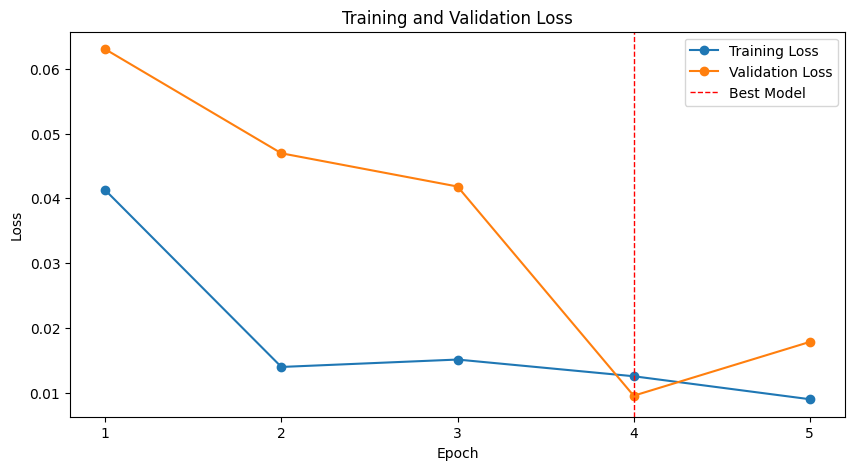

In [28]:
# Plot history
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), history['train_loss'], label='Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), history['val_loss'], label='Validation Loss', marker='o')
best_epoch = np.argmin(history['val_loss'])
plt.axvline(best_epoch + 1, color='r', linestyle='--', lw=1, label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [47]:
from tqdm import tqdm

def evaluate(model, test_loader, device, threshold=0.5):
    model.eval()
    total_pairs = 0
    correct = 0
    all_distances = []
    all_labels = []
    all_predictions = []
    running_loss = 0.0

    with torch.no_grad():
        # Wrap the test_loader with tqdm for progress tracking
        for i, (images, labels) in enumerate(tqdm(test_loader, desc="Evaluating", total=len(test_loader))):
            img1 = images[:, 0, :, :, :].to(device)
            img2 = images[:, 1, :, :, :].to(device)
            labels = labels.float().to(device)

            embeddings1, embeddings2 = model(img1, img2)

            distances = torch.nn.functional.pairwise_distance(embeddings1, embeddings2)
            loss = contrastive_loss(embeddings1, embeddings2, labels)
            running_loss += loss.item()

            predictions = (distances < threshold).float()
            
            total_pairs += labels.size(0)
            correct += (predictions == labels).sum().item()
            
            all_distances.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate all metrics
    accuracy = correct / total_pairs
    avg_loss = running_loss / len(test_loader)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    fpr, tpr, thresholds = roc_curve(all_labels, [-d for d in all_distances])
    auc_score = auc(fpr, tpr)

    print(f"\nTest Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'average_loss': avg_loss,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }


Evaluating: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Test Results:
Average Loss: 0.0234
Accuracy: 0.9387
Precision: 0.8910
Recall: 0.9533
F1-Score: 0.9211
AUC Score: 0.9825


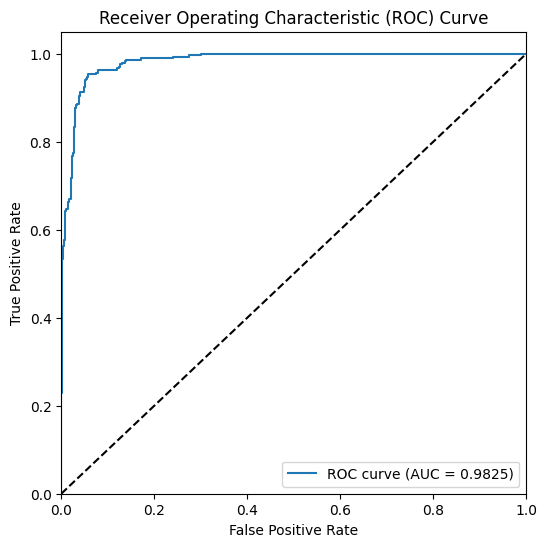

In [56]:
metrics = evaluate(model, test_loader, device, threshold=0.5)

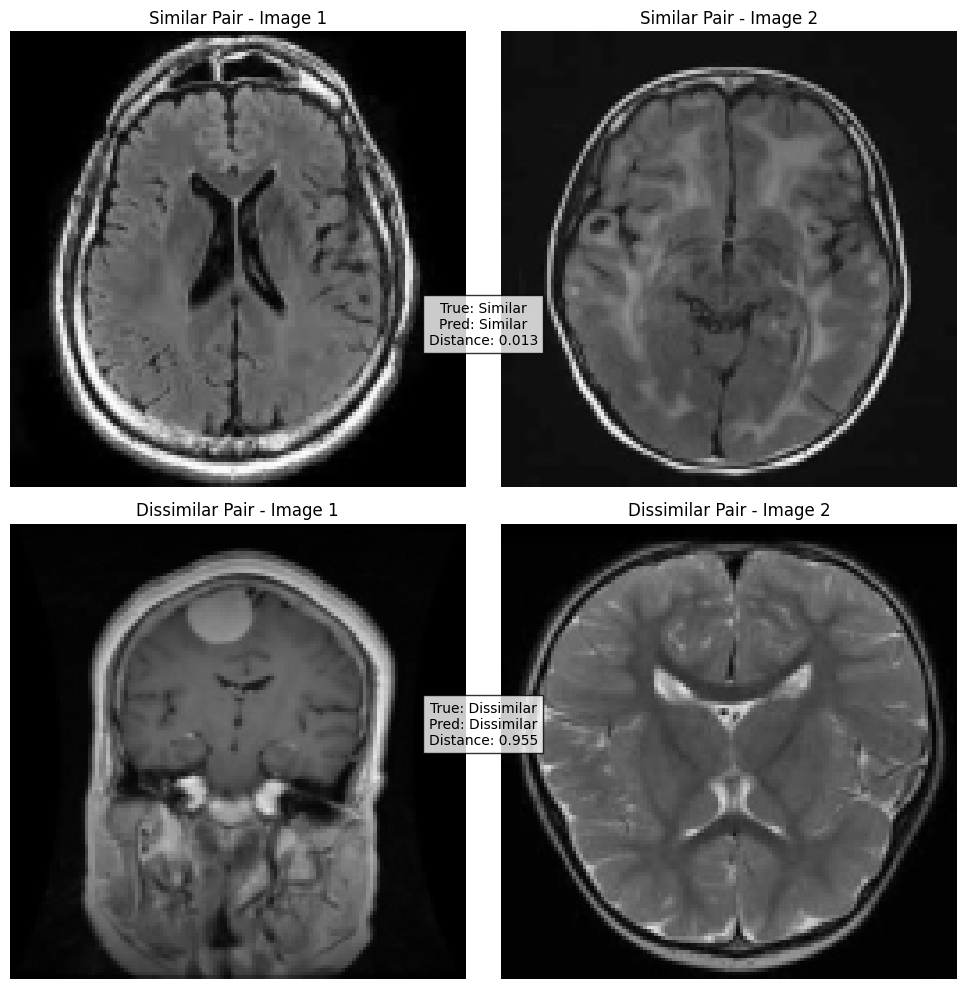

In [57]:
def get_random_pairs(dataset, device):
    # Get one similar pair (label=1)
    similar_indices = [i for i, label in enumerate(dataset.pair_labels) if label == 1]
    similar_idx = random.choice(similar_indices)
    
    # Get one dissimilar pair (label=0)
    dissimilar_indices = [i for i, label in enumerate(dataset.pair_labels) if label == 0]
    dissimilar_idx = random.choice(dissimilar_indices)
    
    # Get both pairs
    similar_pair, similar_label = dataset[similar_idx]
    dissimilar_pair, dissimilar_label = dataset[dissimilar_idx]
    
    # Move to device
    similar_pair = similar_pair.to(device)
    dissimilar_pair = dissimilar_pair.to(device)
    
    return similar_pair, similar_label, dissimilar_pair, dissimilar_label

def predict_pair(model, img_pair, device):
    model.eval()
    with torch.no_grad():
        # Get embeddings
        img1 = img_pair[0].unsqueeze(0)  # Add batch dimension
        img2 = img_pair[1].unsqueeze(0)
        
        emb1, emb2 = model(img1, img2)
        
        # Calculate distance
        distance = F.pairwise_distance(emb1, emb2)
        
        # Predict (similar if distance < threshold)
        prediction = 1 if distance < 0.5 else 0
        
        return prediction, distance.item()

def visualize_pairs_with_predictions(model, dataset, device):
    # Get random pairs
    similar_pair, similar_label, dissimilar_pair, dissimilar_label = get_random_pairs(dataset, device)
    
    # Get predictions
    similar_pred, similar_dist = predict_pair(model, similar_pair, device)
    dissimilar_pred, dissimilar_dist = predict_pair(model, dissimilar_pair, device)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Similar pair
    axes[0, 0].imshow(similar_pair[0].cpu().squeeze().permute(1, 2, 0))
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Similar Pair - Image 1')
    
    axes[0, 1].imshow(similar_pair[1].cpu().squeeze().permute(1, 2, 0))
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Similar Pair - Image 2')
    
    # Dissimilar pair
    axes[1, 0].imshow(dissimilar_pair[0].cpu().squeeze().permute(1, 2, 0))
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Dissimilar Pair - Image 1')
    
    axes[1, 1].imshow(dissimilar_pair[1].cpu().squeeze().permute(1, 2, 0))
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Dissimilar Pair - Image 2')
    
    # Add predictions as text
    similar_text = f'True: Similar\nPred: {"Similar" if similar_pred == 1 else "Dissimilar"}\nDistance: {similar_dist:.3f}'
    dissimilar_text = f'True: Dissimilar\nPred: {"Similar" if dissimilar_pred == 1 else "Dissimilar"}\nDistance: {dissimilar_dist:.3f}'
    
    plt.figtext(0.5, 0.65, similar_text, ha='center', bbox=dict(facecolor='white', alpha=0.8))
    plt.figtext(0.5, 0.25, dissimilar_text, ha='center', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Usage:
visualize_pairs_with_predictions(model, test_dataset, device)

**Grad-CAM**

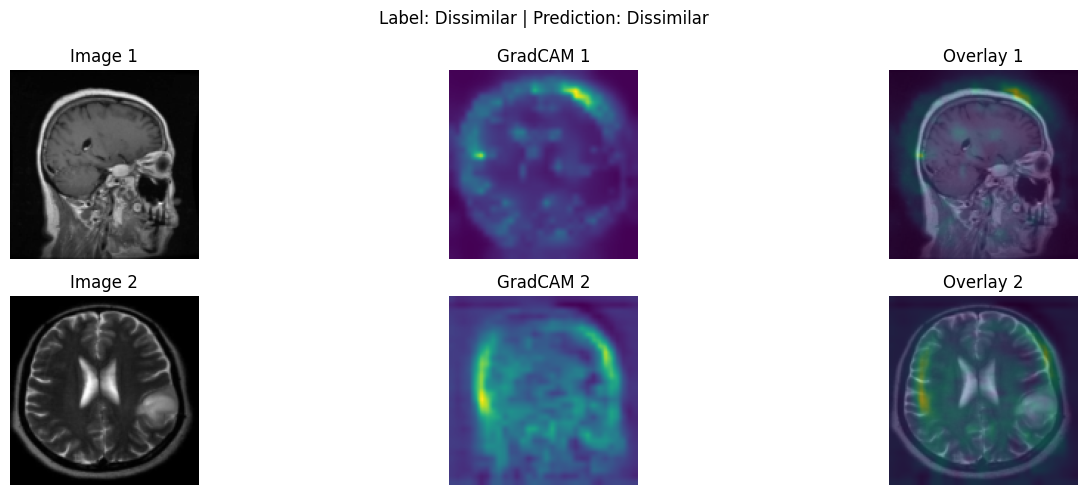

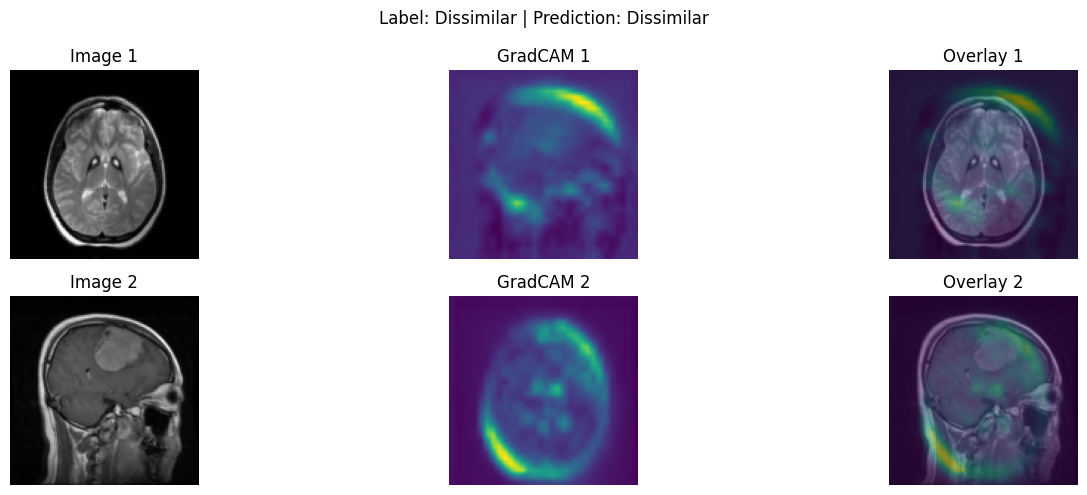

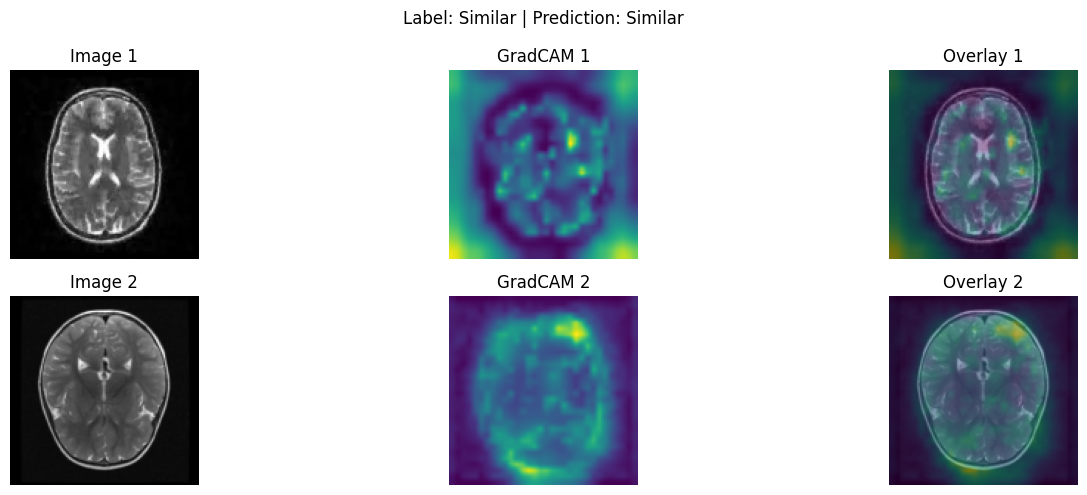

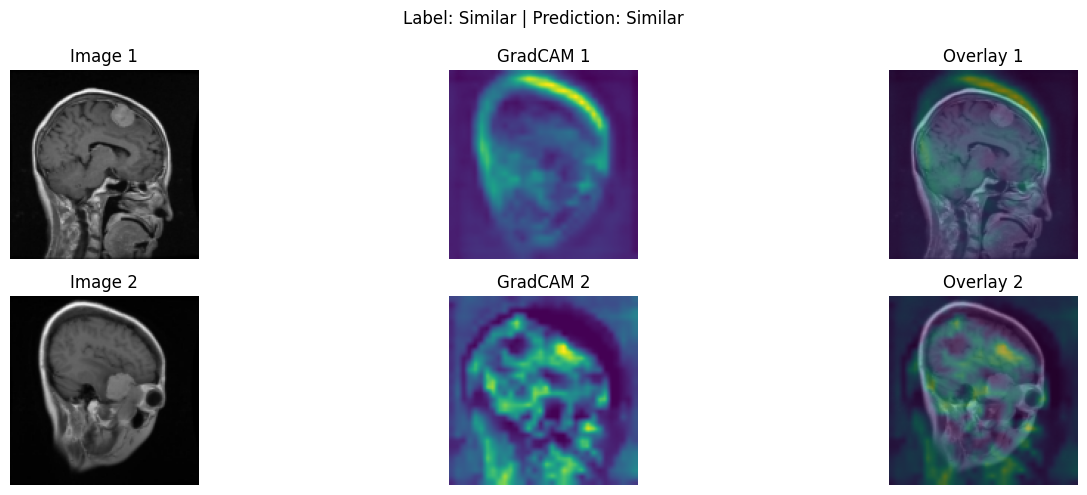

In [58]:
class GradCAMWeighted:
    def __init__(self, model, target_layers):
        """
        Grad-CAM implementation that combines contributions from multiple layers,
        weighted by their gradient-based importance.

        :param model: The model to analyze.
        :param target_layers: A dictionary of target layers to include in Grad-CAM.
        """
        self.model = model
        self.target_layers = target_layers
        self.gradients = {}
        self.features = {}

        # Register hooks for each target layer
        for layer_name, layer in self.target_layers.items():
            layer.register_forward_hook(self.save_features(layer_name))
            layer.register_full_backward_hook(self.save_gradients(layer_name))

    def save_features(self, layer_name):
        """Save the output features of a layer during the forward pass."""
        def hook(module, input, output):
            self.features[layer_name] = output.to(device)
        return hook

    def save_gradients(self, layer_name):
        """Save the gradients of a layer during the backward pass."""
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0].to(device)
        return hook

    def generate_cam(self, input_tensor):
        """
        Generate a combined Grad-CAM for the input tensor, weighted by gradient importance.

        :param input_tensor: The input tensor for the model.
        :return: A combined Grad-CAM heatmap.
        """
        # Reset stored gradients and features
        self.features = {}
        self.gradients = {}

        # Forward pass
        embedding1, embedding2 = self.model(input_tensor[0], input_tensor[1])

        # Compute the distance and backpropagate
        distance = F.pairwise_distance(embedding1, embedding2)
        distance.backward()

        # Compute CAM for each layer and calculate importance
        cams = []
        layer_importances = []
        for layer_name in self.target_layers.keys():
            gradients = self.gradients[layer_name].squeeze()
            features = self.features[layer_name].squeeze()

            # Global average pooling of gradients
            weights = gradients.mean(dim=(1, 2))

            # Weighted combination of forward activation maps
            cam = torch.zeros(features.shape[1:], device=device)
            for i, w in enumerate(weights):
                cam += w * features[i]

            # ReLU and normalize
            cam = F.relu(cam)
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)  # Avoid division by zero
            cams.append(cam)

            # Compute layer importance (e.g., gradient norm)
            layer_importances.append(gradients.norm().item())

        # Normalize layer importances
        layer_importances = torch.tensor(layer_importances, device=device)
        layer_importances = layer_importances / layer_importances.sum()

        final_cam = torch.zeros(cams[0].shape, device=device)

        for cam, imp in zip(cams, layer_importances):
            # Interpolate cam to match the final_cam size
            cam = cv2.resize(cam.detach().cpu().numpy(), (final_cam.shape[1], final_cam.shape[0]))
            # Convert back to tensor
            cam = torch.tensor(cam, device=device)
            cam = cam * imp
            final_cam += cam

        return final_cam.detach().cpu().numpy()

import torch.nn.functional as F

def visualize_weighted_gradcam(model, img1, img2, label, grad_cam_weighted):
    """
    Visualize Grad-CAM for a pair of images using weighted contributions.

    :param model: The model being analyzed.
    :param img1: The first input image.
    :param img2: The second input image.
    :param label: The ground truth label for the pair.
    :param grad_cam_weighted: The GradCAMWeighted instance.
    """
    model.eval()
    
    # Generate CAM for both images
    cam1 = grad_cam_weighted.generate_cam((img1, img2))
    cam2 = grad_cam_weighted.generate_cam((img2, img1))

    # Resize to match image size
    cam1 = cv2.resize(cam1, (IMG_SIZE, IMG_SIZE))
    cam2 = cv2.resize(cam2, (IMG_SIZE, IMG_SIZE))
    
    # Convert tensors to numpy for visualization
    img1_np = img1.squeeze().cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.squeeze().cpu().numpy().transpose(1, 2, 0)
    
    # Normalize images if needed
    img1_np = (img1_np - img1_np.min()) / (img1_np.max() - img1_np.min())
    img2_np = (img2_np - img2_np.min()) / (img2_np.max() - img2_np.min())
    
    # Forward pass through model to get embeddings and compute pairwise distance
    embedding1, embedding2 = model(img1, img2)
    distance = F.pairwise_distance(embedding1, embedding2)

    # Prediction based on distance (threshold for similarity)
    prediction = 1 if distance < 0.5 else 0  # Example threshold, can be adjusted
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Original images
    plt.subplot(2, 3, 1)
    plt.imshow(img1_np)
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(img2_np)
    plt.title('Image 2')
    plt.axis('off')
    
    # Grad-CAM heatmaps
    plt.subplot(2, 3, 2)
    plt.imshow(cam1, cmap='viridis')
    plt.title('GradCAM 1')
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(cam2, cmap='viridis')
    plt.title('GradCAM 2')
    plt.axis('off')
    
    # Overlayed images
    plt.subplot(2, 3, 3)
    plt.imshow(img1_np)
    plt.imshow(cam1, cmap='viridis', alpha=0.5)
    plt.title('Overlay 1')
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(img2_np)
    plt.imshow(cam2, cmap='viridis', alpha=0.5)
    plt.title('Overlay 2')
    plt.axis('off')
    
    # Display label and model's prediction
    plt.suptitle(f'Label: {"Similar" if label == 1 else "Dissimilar"} | Prediction: {"Similar" if prediction == 1 else "Dissimilar"}')
    plt.tight_layout()
    plt.show()

# Example usage with test samples
def analyze_sample_pairs_weighted(model, test_loader, grad_cam_weighted, num_similar=2, num_dissimilar=2):
    """
    Analyze 2 similar and 2 dissimilar sample pairs from the test set using weighted Grad-CAM.
    
    :param model: The model being analyzed.
    :param test_loader: The DataLoader for the test set.
    :param grad_cam_weighted: The GradCAMWeighted instance.
    :param num_similar: The number of similar pairs to analyze.
    :param num_dissimilar: The number of dissimilar pairs to analyze.
    """
    model.eval()

    similar_pairs = 0
    dissimilar_pairs = 0
    dataiter = iter(test_loader)

    # Loop to collect similar and dissimilar pairs
    while similar_pairs < num_similar or dissimilar_pairs < num_dissimilar:
        images, label = next(dataiter)
        
        # Ensure we have both similar and dissimilar pairs
        if label[0] == 1 and similar_pairs < num_similar:  # Similar pair
            img1 = images[0, 0].unsqueeze(0).to(device)
            img2 = images[0, 1].unsqueeze(0).to(device)
            visualize_weighted_gradcam(model, img1, img2, label[0], grad_cam_weighted)
            similar_pairs += 1
        elif label[0] == 0 and dissimilar_pairs < num_dissimilar:  # Dissimilar pair
            img1 = images[0, 0].unsqueeze(0).to(device)
            img2 = images[0, 1].unsqueeze(0).to(device)
            visualize_weighted_gradcam(model, img1, img2, label[0], grad_cam_weighted)
            dissimilar_pairs += 1


# Example: Define the target layers
target_layers = {
    "layer1": model.resnet.layer1[0].conv1,
    "layer2": model.resnet.layer2[0].conv1,
    "layer3": model.resnet.layer3[0].conv1,
    "layer4": model.resnet.layer4[0].conv1,
}

# Instantiate the Grad-CAM implementation
grad_cam_weighted = GradCAMWeighted(model, target_layers)
# Example usage:
analyze_sample_pairs_weighted(model, test_loader, grad_cam_weighted, num_similar=2, num_dissimilar=2)
